# Residual Neural Network for Nose Reconstruction

Author: Rafael Godoy

LinkedIn: https://www.linkedin.com/in/Rafael-Godoy-ML-Eng

Github: https://github.com/RafaelSilvaGodoy

In this notebook it will be developed a NN for **image recreation**. The task consists in generate a nose to a face once the original image has it covered.

The initial porpouse of this application was to build mose prosthesis to people who has a defomormed nose.

For this kind of job it wil lbe used a **Residual NN**.

The dataset was provided by: https://github.com/tkarras/progressive_growing_of_gans.

The images must be treated to the following configurations:
- RGB;
- 64x64x3;
- Luminosity intensity normalized between 0 and 1;

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import tensorflow as tf

%matplotlib inline

This cell imports the files from the driver (If you are using Colab).

The dataset was too big to be uploaded on GitHub and is avaiable on the link in the description.

In [2]:
%%capture

!gdown --id 1s_3LKghAzNtM722oSvXbQN1vIry60CMF
!gdown --id 112pUB-v4mAhMVCP_ZJxXg4xks6rYp5jK

In [3]:
# Read the dataset
hf = h5py.File('data64.h5','r')

# Create the variables for training, validation and test
x_train0 = np.array(hf.get('x_train'))
y_train0 = np.array(hf.get('y_train'))
x_val0 = np.array(hf.get('x_val'))
y_val0 = np.array(hf.get('y_val'))
x_test0 = np.array(hf.get('x_test'))
y_test0 = np.array(hf.get('y_test'))

# In this step it was reduced the number of images due to computational time
x_train = x_train0[:2300]
y_train = y_train0[:2300]
x_val = x_val0[:300]
y_val = y_val0[:300]
x_test = x_test0[:300]
y_test = y_test0[:300]

img_size = x_train.shape[1:4]

# CLose the data file
hf.close()

print('Training images dimentions (input/output) =', x_train.shape, y_train.shape)
print('Validation images dimentions (input/output) =', x_val.shape, y_val.shape)               
print('Test images dimentions (input/output) =', x_test.shape, y_test.shape)

Training images dimentions (input/output) = (2300, 64, 64, 3) (2300, 64, 64, 3)
Validation images dimentions (input/output) = (300, 64, 64, 3) (300, 64, 64, 3)
Test images dimentions (input/output) = (300, 64, 64, 3) (300, 64, 64, 3)


## Input/Output examples

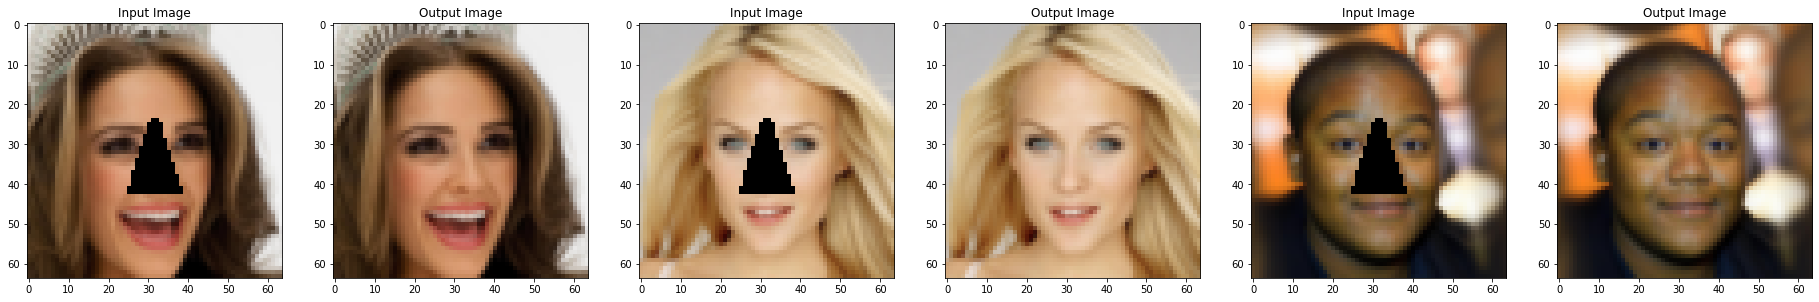

In [4]:
index = 0

f, pos = plt.subplots(1, 6, figsize=(32, 32))
for i in range(3):
  pos[2*i].imshow(x_train[index])
  pos[2*i].set_title('Input Image')
  index += 1

index = 0 
for j in range(3):
  pos[1 + 2*j].imshow(y_train[index])
  pos[1 + 2*j].set_title('Output Image')
  index += 1
plt.show()


## Function to built a **Residual Block** for complex network train.

Residual block reference: https://en.wikipedia.org/wiki/Residual_neural_network

In [5]:
from tensorflow.keras import layers

def residual_block(X, n, dim):
    """`
    Inputs: 
        X = Input tensor 
        n = Number of filters
        dim = Filter's dimention
    
    Output:
        A2 -> Output tensor
    """
    
    A1 = layers.Conv2D(n, dim, strides = 1, padding = 'same', activation = 'relu') (X)
    Z2 = layers.Conv2D(n, dim, strides = 1, padding = 'same', activation = 'linear') (A1)

    ZX = layers.Add()([Z2, X])
    A2 = layers.Activation('relu')(ZX)
    
    return A2

# Model Build

In [6]:

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import plot_model


input_shape = (64, 64, 3)

X0 = layers.Input(shape=input_shape)

X1 = layers.Conv2D(128, (5,5), strides=1, padding='same', activation='relu')(X0)

X2 = residual_block(X1, 128, (5,5))

X3 = layers.Conv2D(256, (5,5), strides = 1, padding = 'same', activation = 'relu')(X2)

X4 = residual_block(X3, 256, (5,5))

X5 = residual_block(X4, 256, (5,5)) 

X6 = layers.Conv2D(128, (5,5), strides = 1, padding = 'same', activation = 'relu')(X5) 

X7 = residual_block(X6, 128, (5,5))

X8 = residual_block(X7, 128, (5,5)) 

X9 = layers.Conv2D(64, (5,5), strides = 1, padding = 'same', activation = 'relu')(X8)

X10 = residual_block(X9, 64, (5,5))

X11 = layers.Conv2D(3, (5,5), strides = 1, padding = 'same', activation = 'linear')(X10)

rna = Model(X0, X11)

rna.summary() 


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 128)  9728        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  409728      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 128)  409728      conv2d_1[0][0]                   
______________________________________________________________________________________________

# Network Architecture

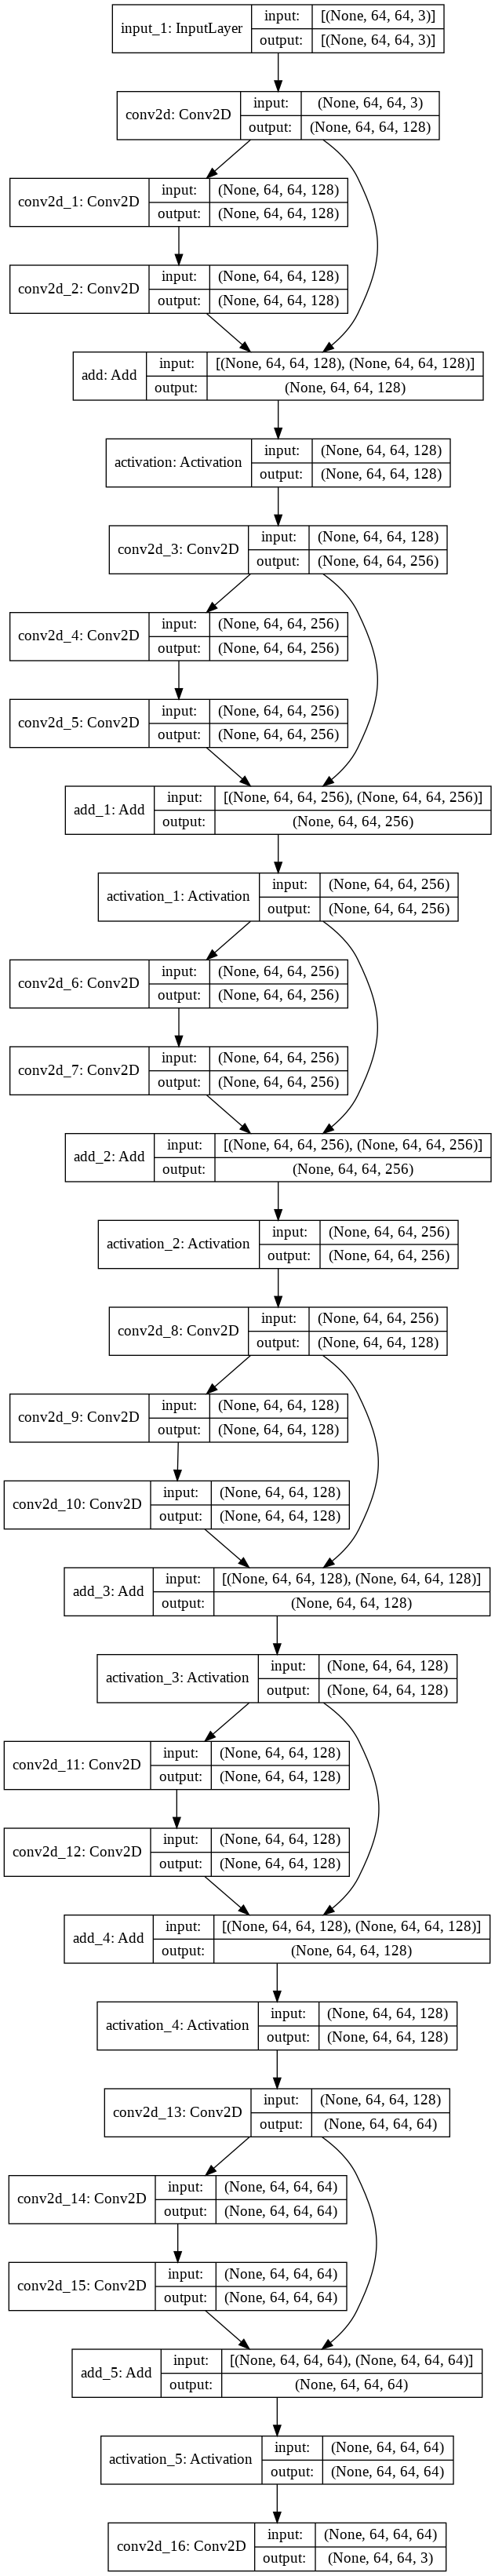

In [7]:
plot_model(rna, to_file='rna.png', show_shapes=True)

# Loss function and Metrics


## Mask

The loss function will be created based on the mask image used on the people's faces. 

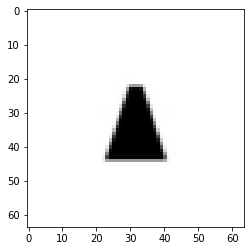

In [8]:
mask0 = imread('mask512.jpg')
mask0 = np.array(mask0)
mask = resize(mask0, (64, 64, 3), preserve_range=True)
mask = mask/255.
plt.imshow(mask)
plt.show()

## Loss Function

Higher weights are given to the mask's pixels and lower weights for the outside pixels. The loss function $L_{total}$ is defined by:

$$L_{total} = L_{valid} + 10L_{hole}$$

where,

$$L_{hole} = \frac {1}{N} \sum_{i=1}^{N}(1 - m_i)|y_{orig(i)} - y_{prev(i)}|$$

$$L_{valid} = \frac {1}{N} \sum_{i=1}^{N}(m_i)|y_{orig(i)} - y_{prev(i)}|$$
 
- $m_i$ : value of the pixel $i$ of the mask;
- $y_{orig(i)}$ : value of the pixel $i$ from the original image without the mask;
- $y_{prev(i)}$ : value of the pixel $i$ from the reconstructed image;
- $N$ : Total number of the image pixel that is 64x64x3;

The function $L_{hole}$ only considers the pixels inside the mask and on the $L_{valid}$ function are only considered pixels out of the mask range.

**Reference:**
Liu ewt al., Image Inpainting for Irregular Holes Using. Computer Vision Foundation.Liu, et al., 2018. (http://openaccess.thecvf.com/content_ECCV_2018/html/Guilin_Liu_Image_Inpainting_for_ECCV_2018_paper.html)

In [9]:
import tensorflow.keras.backend as K

def l1(y_true, y_pred):
    """Calculate the L1 loss used in loss calculations"""
    return K.mean(K.abs(y_pred - y_true))
 
# L_hole function
def loss_hole(mask, y_true, y_pred):
    """Pixel L1 loss within the mask"""
    return l1((1-mask) * y_true, (1-mask) * y_pred)
    
# L_valid function   
def loss_valid(mask, y_true, y_pred):
    """Pixel L1 loss outside the mask"""
    return l1(mask * y_true, mask * y_pred)

In [10]:
def L_total(y_true, y_pred):
    """
    Input:
        y_true = Real output 
        y_pred = Image with nose recreated
        
    Output:
        Ltotal
    """         
    
    #  mask image
    mask = resize(mask0, (64, 64, 3), preserve_range=True)/255.
    
    Lhole = loss_hole(mask, y_true, y_pred)
    Lvalid = loss_valid(mask, y_true, y_pred)
    Ltotal = Lvalid + (10 * Lhole)
    
    return Ltotal

## Metric

The metric used in this problem will be Peak signal-to-noise ratio (PSNR), https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio.

 The PSNR shows the relation between the highest signal and the noise presented in the signal.


$$MSE = \frac {1}{N} \sum_{i=1}^{N}[y_{orig(i)} - y_{prev(i)}]^{2}$$

- $y_{orig(i)}$ value of the pixel $i$ from the original image;
- $y_{prev(i)}$ value of the pixel $i$ from the created image;
- $N$ total number o pixels on the image.

The $PSNR$ is defined by:

$$PSNR = 10 .log_{10}({\frac {max^2}{MSE}}) = 20 .log_{10}(max) - 10 .log_{10}(MSE)$$

Once the $max$ value of the image is 1 (the image was normalized between 0 and 1), the equation can be simplified to:

$$PSNR = -10.log_{10}(MSE)$$

Using this metric, the higher is the PSNR, the better is the image created.

In [11]:
def PSNR(y_true, y_pred):
    """
    Input:
        y_true = Real output 
        y_pred = Image with nose recreated
        
    Output:
        psrn
    """        
    
    ten = tf.constant(10.0, dtype=y_true.dtype) 
     
    mse = K.mean(K.square(y_true - y_pred))
    psnr = -ten * (K.log(mse) / K.log(ten))
    
    return psnr

In [12]:
from tensorflow.keras import optimizers

adam = optimizers.Adam(learning_rate = 0.001)
rna.compile(loss = L_total, metrics = PSNR, optimizer = adam)

history = rna.fit(x_train, y_train, epochs = 75, validation_data = (x_val, y_val), verbose = 1)

Epoch 1/75
72/72 [==============================] - 161s 1s/step - loss: 143.1351 - PSNR: 10.8831 - val_loss: 0.1668 - val_PSNR: 16.1736
Epoch 2/75
72/72 [==============================] - 83s 1s/step - loss: 0.1344 - PSNR: 18.4501 - val_loss: 0.1146 - val_PSNR: 20.1910
Epoch 3/75
72/72 [==============================] - 85s 1s/step - loss: 0.1070 - PSNR: 20.9265 - val_loss: 0.0942 - val_PSNR: 22.2087
Epoch 4/75
72/72 [==============================] - 83s 1s/step - loss: 0.0922 - PSNR: 22.3765 - val_loss: 0.0863 - val_PSNR: 23.0468
Epoch 5/75
72/72 [==============================] - 85s 1s/step - loss: 0.0823 - PSNR: 23.6212 - val_loss: 0.0863 - val_PSNR: 23.3652
Epoch 6/75
72/72 [==============================] - 83s 1s/step - loss: 0.0756 - PSNR: 24.4055 - val_loss: 0.0928 - val_PSNR: 23.0143
Epoch 7/75
72/72 [==============================] - 85s 1s/step - loss: 0.0716 - PSNR: 24.9451 - val_loss: 0.0677 - val_PSNR: 25.1802
Epoch 8/75
72/72 [==============================] - 83s 1s/

# Results


In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'PSNR', 'val_loss', 'val_PSNR'])

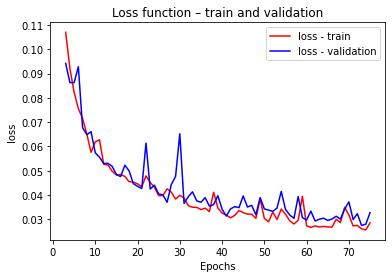

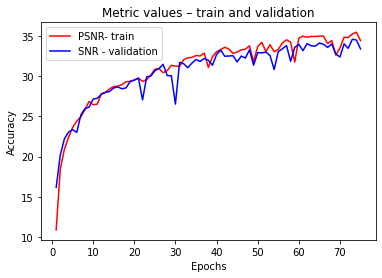

In [14]:

loss = history_dict['loss']
acc = history_dict['PSNR']
val_loss = history_dict['val_loss']
val_acc = history_dict['val_PSNR']


epochs = range(1, len(loss) + 1)


plt.plot(epochs[2:], loss[2:], 'r', label='loss - train')
plt.plot(epochs[2:], val_loss[2:], 'b', label='loss - validation')
plt.title('Loss function – train and validation')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.plot(epochs, acc, 'r', label='PSNR- train')
plt.plot(epochs, val_acc, 'b', label='SNR - validation')
plt.title('Metric values – train and validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:

cm_train = rna.evaluate(x_train, y_train)
cm_val = rna.evaluate(x_val, y_val)
cm_test = rna.evaluate(x_test, y_test)

10/10 [==============================] - 3s 338ms/step - loss: 0.0323 - PSNR: 33.5030


## Results Examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


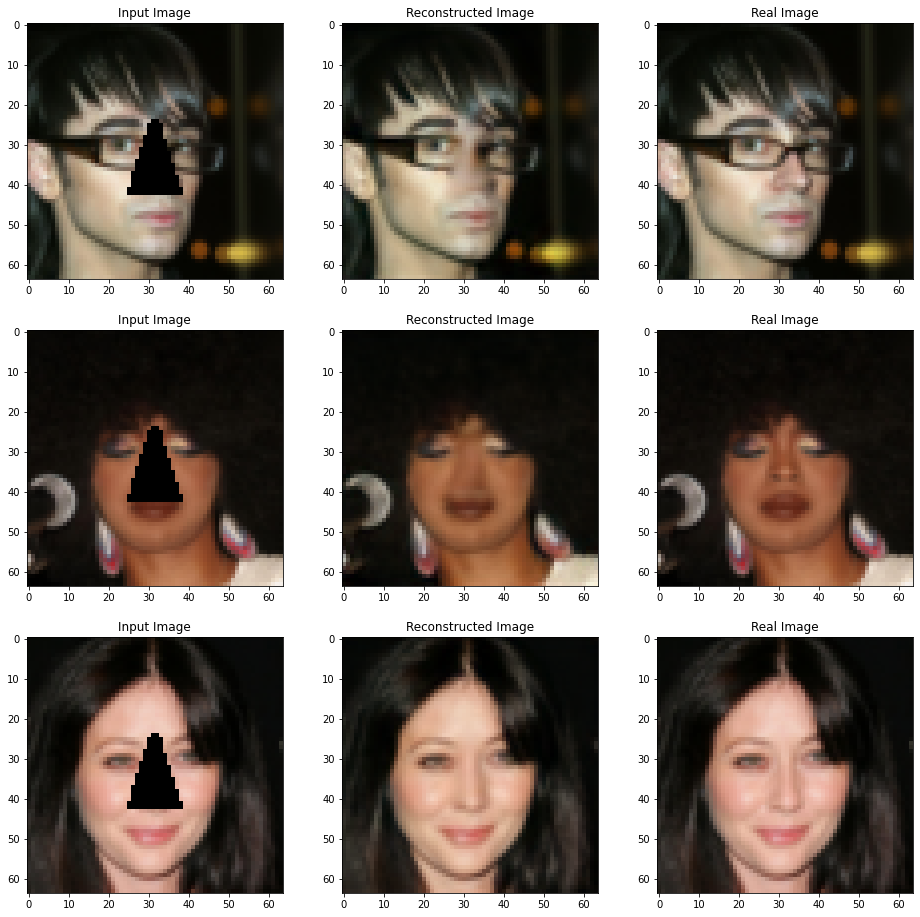

In [23]:
index = 5

f, pos = plt.subplots(3, 3, figsize=(16, 16))

for k in range(3):

    xindex = np.expand_dims(x_test[index], axis=0)
    y_pred = rna.predict(xindex)

    pos[k,0].imshow(x_test[index])
    pos[k,0].set_title('Input Image')

    pos[k,1].imshow(y_pred[0])
    pos[k,1].set_title('Reconstructed Image')
    
    pos[k,2].imshow(y_test[index])
    pos[k,2].set_title('Real Image')

    index += 1

plt.show()

# Conclusion

The residual block is essential when training complex NN due to the lost of gradient through the layers.

In this example, low quality images where used due to computational time to process it.

In some cases the NN managed to recreate close to real nose and in others didn't.

This network was trained with 2000 images 64x64x3 and took almost 2 hours.

To improve the results, a high computational power is a must and also more images to train. Different network architectures could also get a better result.
